<a> <img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In [ ]:
In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

# import required libraries

In [285]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [65]:
 !wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-12-28 09:23:26--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2019-12-28 09:23:27 (304 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [286]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [385]:
df.shape
df1=df.copy()

### Convert to date time object 

In [287]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.drop(columns='Unnamed: 0.1', axis =1, inplace=True)
df.head()

,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [288]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [70]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

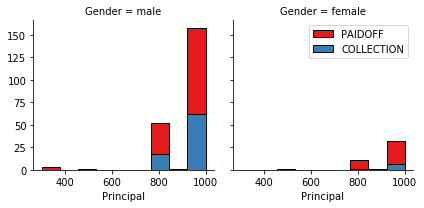

In [71]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

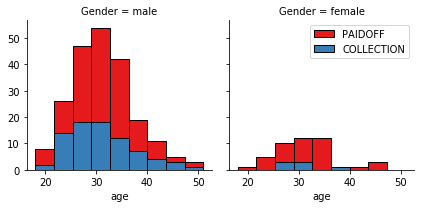

In [72]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

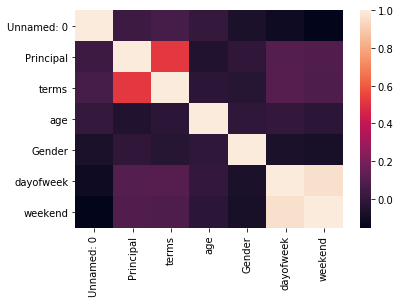

In [199]:
sns.heatmap(df.corr())

In [214]:
df['age'].value_counts()

2    222
3     61
1     56
4      7
Name: age, dtype: int64

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

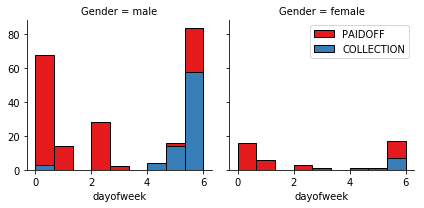

In [289]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [290]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


In [77]:
# If we want to change the spelling of 'Bechalor' use- df.replace(to_replace='Bechalor', value='Bachelor', inplace= True )

## Convert Categorical features to numerical values

Lets look at gender:

In [291]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [334]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [335]:
df.Gender.dtypes

dtype('int64')

## One Hot Encoding  
#### How about education?

In [336]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [337]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [338]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
#Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


### Feature selection

Lets defind feature sets, X:

In [339]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


What are our lables?

In [340]:
target=pd.get_dummies(df['loan_status'])
target.drop(['COLLECTION'], axis = 1,inplace=True)
target.head()

,PAIDOFF
0,1
1,1
2,1
3,1
4,1


In [341]:
y = target.values
y[0:5]

array([[1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [342]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.07624929, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.07624929, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

### Splitting the data and training the model

In [343]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=4)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (311, 9) (311, 1)
Test set: (35, 9) (35, 1)


### Modelling KNN algorithm

In [344]:
from sklearn.neighbors import KNeighborsClassifier

In [345]:
k=7
knn = KNeighborsClassifier(n_neighbors=k).fit(x_train, y_train.ravel())
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

In [346]:
pred = knn.predict(x_test)
pred[0:5]

array([1, 1, 1, 1, 1], dtype=uint8)

### Model Evaluation

In [347]:
from sklearn.metrics import accuracy_score, classification_report,jaccard_similarity_score

In [348]:
print('Train accuracy score: ' , accuracy_score(y_train, knn.predict(x_train)))
print('validation set accuracy score', accuracy_score(y_test, pred))

Train accuracy score:  0.8006430868167203
validation set accuracy score 0.8857142857142857


In [349]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       0.96      0.90      0.93        30

   micro avg       0.89      0.89      0.89        35
   macro avg       0.77      0.85      0.80        35
weighted avg       0.91      0.89      0.89        35



The best accuarcy is  0.8857142857142857 with k = 7


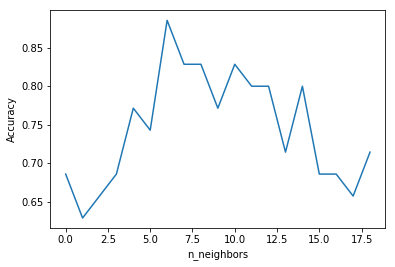

In [350]:
ks=20
mean_acc=[]

for x in range(1,ks):
    knn1 = KNeighborsClassifier(n_neighbors=x).fit(x_train,y_train.ravel())
    pred1 = knn1.predict(x_test)
    mean_acc.append(accuracy_score(y_test,pred1))
    
arr= np.asarray(mean_acc)


plt.plot(range(ks-1), arr)
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")

print('The best accuarcy is ',arr.max(), 'with k =' , arr.argmax()+1)

# Decision Tree

## Modelling

In [351]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier(criterion='entropy', max_depth=6).fit(x_train,y_train)
dpred=dtree.predict(x_test)

In [352]:
print (dpred [0:5])

[0 1 1 1 1]


## Evaluation

In [353]:
print("DecisionTrees's training set Accuracy: ", accuracy_score(y_train, dtree.predict(x_train)))
print("DecisionTrees's validation set Accuracy: ", accuracy_score(y_test, dpred))

DecisionTrees's training set Accuracy:  0.7845659163987139
DecisionTrees's validation set Accuracy:  0.6857142857142857


In [354]:
print (classification_report(y_test,dpred))

              precision    recall  f1-score   support

           0       0.20      0.40      0.27         5
           1       0.88      0.73      0.80        30

   micro avg       0.69      0.69      0.69        35
   macro avg       0.54      0.57      0.53        35
weighted avg       0.78      0.69      0.72        35



In [396]:
k=10
dtree_acc=[]

for x in range(1,k):
    dtree1=DecisionTreeClassifier(criterion='entropy', max_depth=x).fit(x_train,y_train.ravel())
    dpred1=dtree1.predict(x_test)
    dtree_acc.append(accuracy_score(y_test, dpred1))

dtree_acc=np.asarray(dtree_acc)
print("DecisionTrees's Accuracy highest accuracy is ", dtree_acc.max(), 'at max_depth: ', dtree_acc.argmax()+1)

DecisionTrees's Accuracy highest accuracy is  0.8571428571428571 at max_depth:  1


## Using Random forests

In [356]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=500).fit(x_train,y_train.ravel())
rpred=rfc.predict(x_test)
print("Random forest Accuracy: ", accuracy_score(y_test, rpred))

Random forest Accuracy:  0.7714285714285715


In [357]:
print (classification_report(y_test,rpred))

              precision    recall  f1-score   support

           0       0.29      0.40      0.33         5
           1       0.89      0.83      0.86        30

   micro avg       0.77      0.77      0.77        35
   macro avg       0.59      0.62      0.60        35
weighted avg       0.81      0.77      0.79        35



## Visualizing the decision tree

In [ ]:
# The following below code 

In [391]:
Feature1 = df1[['Principal','terms','age','Gender','weekend']]
Feature1 = pd.concat([Feature1,pd.get_dummies(df1['education'])], axis=1)
#Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature1.head()

x1=Feature1
y1=df1['loan_status'].values

from sklearn.model_selection import train_test_split
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1,y1,test_size=0.1, random_state=4)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (311, 9) (311, 1)
Test set: (35, 9) (35, 1)


In [394]:
y1[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [386]:
!pip install pydotplus 

In [387]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

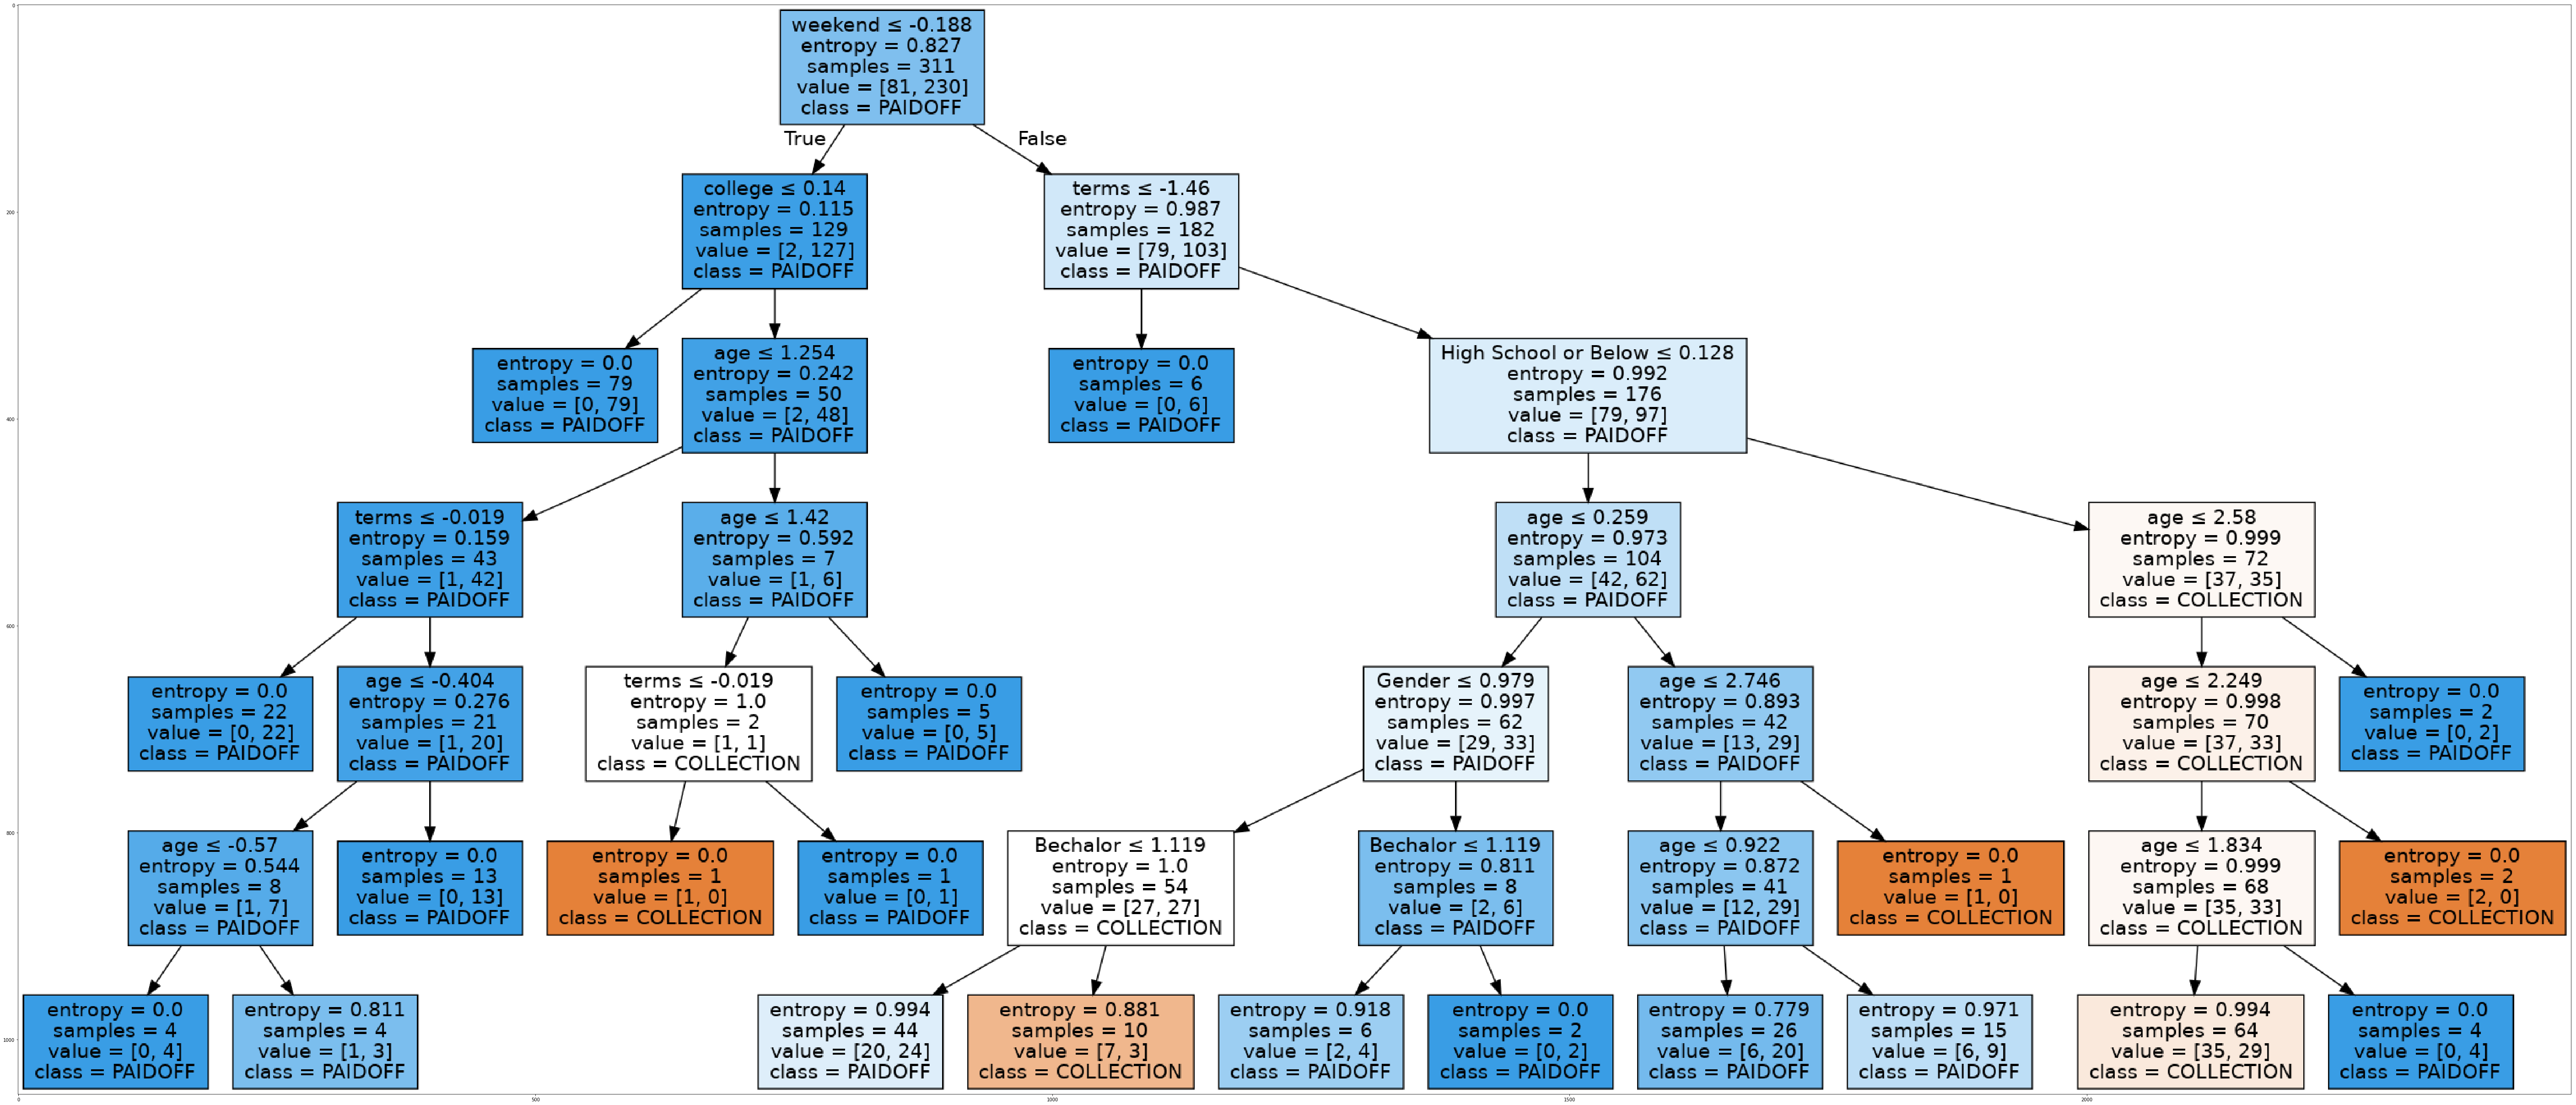

In [395]:
dot_data = StringIO()
filename = "drugtree.png"
featureNames = Feature1.columns[0:9]
targetNames = df1["loan_status"].unique().tolist()
out=tree.export_graphviz(dtree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train1), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')
plt.show()

# Support Vector Machine

In [358]:
from sklearn.svm import SVC

In [359]:
svc_model = SVC(kernel='linear' , gamma=1, C=1).fit(x_train, y_train.ravel())

In [360]:
spred=svc_model.predict(x_test)
print(spred[0:5])

[1 1 1 1 1]


In [361]:
print('SVM train set accuracy is :' , accuracy_score(y_train, svc_model.predict(x_train)))
print('SVM validation set accuracy is :' , accuracy_score(y_test,spred))

SVM train set accuracy is : 0.7395498392282959
SVM validation set accuracy is : 0.8571428571428571


In [362]:
print(classification_report(y_test,spred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.86      1.00      0.92        30

   micro avg       0.86      0.86      0.86        35
   macro avg       0.43      0.50      0.46        35
weighted avg       0.73      0.86      0.79        35



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [363]:
kernel ={'linear', 'rbf','poly'}

for index,value in enumerate(kernel):
    svm_model=SVC(kernel=value).fit(x_train, y_train.ravel())
    s=svm_model.predict(x_test)
    print('accuracy of %s kernel is' %value , accuracy_score(y_test,s))

accuracy of rbf kernel is 0.7714285714285715
accuracy of poly kernel is 0.8285714285714286
accuracy of linear kernel is 0.8571428571428571


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# Using GridSearch to find the best parameters for SVM

In [364]:
from sklearn.model_selection import GridSearchCV

In [365]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 

In [366]:
grid= GridSearchCV(SVC(),param_grid, refit=True, verbose=2)
grid.fit(x_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ...........

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/o

[CV] .................................. C=10, gamma=0.1, total=   0.0s
[CV] C=10, gamma=0.01 ................................................
[CV] ................................. C=10, gamma=0.01, total=   0.0s
[CV] C=10, gamma=0.01 ................................................


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. C=10, gamma=0.01, total=   0.0s
[CV] C=10, gamma=0.01 ................................................
[CV] ................................. C=10, gamma=0.01, total=   0.0s
[CV] C=10, gamma=0.001 ...............................................


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

[CV] ................................ C=10, gamma=0.001, total=   0.0s
[CV] C=10, gamma=0.001 ...............................................
[CV] ................................ C=10, gamma=0.001, total=   0.0s
[CV] C=10, gamma=0.001 ...............................................
[CV] ................................ C=10, gamma=0.001, total=   0.0s
[CV] C=100, gamma=1 ..................................................
[CV] ................................... C=100, gamma=1, total=   0.0s
[CV] C=100, gamma=1 ..................................................
[CV] ................................... C=100, gamma=1, total=   0.0s
[CV] C=100, gamma=1 ..................................................
[CV] ................................... C=100, gamma=1, total=   0.0s
[CV] C=100, gamma=0.1 ................................................
[CV] ................................. C=100, gamma=0.1, total=   0.0s
[CV] C=100, gamma=0.1 ................................................
[CV] .

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [367]:
gpred=grid.predict(x_test)

In [368]:
grid.best_params_

{'C': 10, 'gamma': 1}

In [369]:
grid.best_estimator_

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [370]:
print('GridSearchCV accuracy is:', accuracy_score(y_test,gpred))
print(classification_report(y_test,gpred))

GridSearchCV accuracy is: 0.8
              precision    recall  f1-score   support

           0       0.38      0.60      0.46         5
           1       0.93      0.83      0.88        30

   micro avg       0.80      0.80      0.80        35
   macro avg       0.65      0.72      0.67        35
weighted avg       0.85      0.80      0.82        35



# Logistic Regression

In [371]:
from sklearn.linear_model import LogisticRegression
lc= LogisticRegression(solver='liblinear').fit(x_train,y_train.ravel())
logpred =lc.predict(x_test)

In [372]:
print('Logistic regression train set accuracy:', accuracy_score(y_train,lc.predict(x_train)))
print('Logistic regression validation set accuracy:', accuracy_score(y_test,logpred))

Logistic regression train set accuracy: 0.7395498392282959
Logistic regression validation set accuracy: 0.8


In [373]:
print(classification_report(y_test,logpred))

              precision    recall  f1-score   support

           0       0.33      0.40      0.36         5
           1       0.90      0.87      0.88        30

   micro avg       0.80      0.80      0.80        35
   macro avg       0.61      0.63      0.62        35
weighted avg       0.82      0.80      0.81        35



# Model Evaluation using Test set

from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [374]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-12-28 11:15:28--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-12-28 11:15:28 (347 MB/s) - ‘loan_test.csv’ saved [3642/3642]



## Load Test set for evaluation 

In [375]:
test_df = pd.read_csv('loan_test.csv')
test_df.age.min()

20

# pre-processing test set

In [376]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.drop(columns='Unnamed: 0.1', axis =1, inplace=True)
test_df.head()

,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [377]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

In [378]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend']=test_df['dayofweek'].apply(lambda x:1 if(x>3) else 0)
test_df.head()
test_df.dtypes

Unnamed: 0                 int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                     int64
dayofweek                  int64
weekend                    int64
dtype: object

In [379]:
Feature1 = test_df[['Principal','terms','age','Gender','weekend']]
Feature1 = pd.concat([Feature1,pd.get_dummies(test_df['education'])], axis=1)
#Feature1.drop(['Master or Above'], axis = 1,inplace=True)
Feature1.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,50,1,0,1,0,0,0
1,300,7,35,0,1,0,0,1,0
2,1000,30,43,1,1,0,1,0,0
3,1000,30,26,0,1,0,0,0,1
4,800,15,29,0,1,1,0,0,0


In [380]:
test_x = Feature1

In [381]:
test_target=pd.get_dummies(test_df['loan_status'])
test_target.drop(['COLLECTION'], axis =1, inplace= True)

test_y=test_target

In [382]:
test_x = preprocessing.StandardScaler().fit(test_x).transform(test_x)
test_x[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.19611614, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  5.09901951, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.19611614, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.19611614,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.19611614, -0.86135677]])

## Evaluation metrics on test set

In [383]:
knn_j = jaccard_similarity_score(test_y, knn.predict(test_x))
knn_f1 = f1_score(test_y, knn.predict(test_x))
dtree_j = jaccard_similarity_score(test_y, dtree.predict(test_x))
dtree_f1 = f1_score(test_y, dtree.predict(test_x))
svm_j = jaccard_similarity_score(test_y, svc_model.predict(test_x))
svm_f1 = f1_score(test_y, svc_model.predict(test_x))
log_j = jaccard_similarity_score(test_y, lc.predict(test_x))
log_f1 = f1_score(test_y, lc.predict(test_x))
log_LL = log_loss(test_y, lc.predict(test_x))

# Report

In [384]:
col_names =  ['Algorithm','Jaccard', 'F1-score','LogLoss']
Report_df = pd.DataFrame(columns = col_names)
Report_df.loc[len(Report_df)] = ['KNN', knn_j,knn_f1,'NA']
Report_df.loc[len(Report_df)] = ['Decision Tree', dtree_j,dtree_f1,'NA']
Report_df.loc[len(Report_df)] = ['SVM', svm_j,svm_f1,'NA']
Report_df.loc[len(Report_df)] = ['Logistic Regression', log_j,log_f1,log_LL]
Report_df.style.hide_index()

Algorithm,Jaccard,F1-score,LogLoss
KNN,0.722222,0.823529,NA
Decision Tree,0.777778,0.846154,NA
SVM,0.740741,0.851064,NA
Logistic Regression,0.796296,0.879121,7.03584


### *From the report it can be concluded that logistic regression performs better than other classification algorithms on test set, where as KNN performs better on training/validation set*

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>